In [1]:
import nmrespy as ne
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

rcParams.update(
        {'font.family': 'serif',
        'font.size': 10,
        'axes.labelsize': 10,
        'figure.figsize': (8., 3.)}
        )

In [2]:
# Parameters for FID generation
sw = 400.e3
pts = 2 ** 14
nspins = 10

# Create oscillators 
# params = [amp, phase, freqs, damp. factor]
params = np.zeros((nspins, 4), dtype="float64")
params[:, 0] = 1.
params[:, 1] = 0.
freqs = np.linspace(-sw / 2, sw / 2, nspins + 2)
freqs = freqs[1:-1]
params[:, 2] = freqs
params[:, 3] = 1000.

In [3]:
# Create an FID from a 400kHz 100e-6 s chirp pulse
chirped = ne.BBQChili.new_from_parameters(
                      params=params,
                      pulse_length=100.e-6,
                      prescan_delay=0.,
                      pulse_bandwidth=400.e3,
                      pts=pts,
                      sw=sw,
                      offset=0.,
                      snr=25.,
                      )

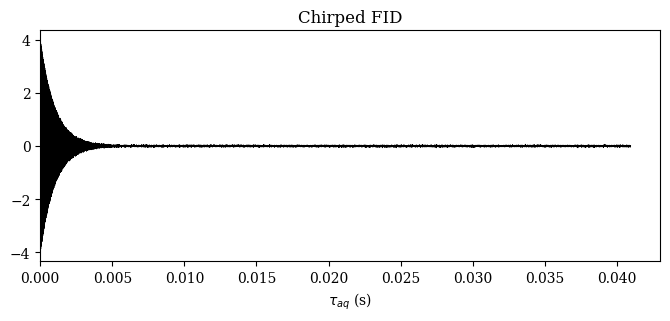

In [4]:
# Free induction decay
fid = chirped.data
timepoints, = chirped.get_timepoints()

fig, axs = plt.subplots()
axs.plot(timepoints, fid.real, c='k', lw=0.5)
axs.set_xlim(timepoints[0])
axs.set_xlabel(r'$\tau_{aq}$ (s)')
axs.set_title('Chirped FID')
plt.show()

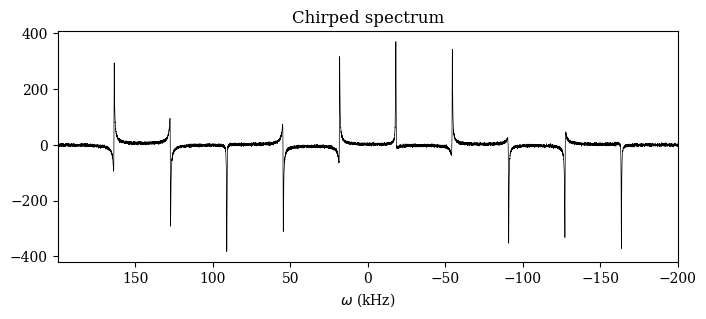

In [5]:
# Original spectrum
spectrum = chirped.spectrum
shifts, = chirped.get_shifts()

fig, axs = plt.subplots()
scaledshifts = shifts / 1e3
axs.plot(scaledshifts, spectrum.real, c='k', lw=0.5)
axs.set_xlim((scaledshifts[0], scaledshifts[-1]))
axs.set_xlabel(r'$\omega$ (kHz)')
axs.set_title('Chirped spectrum')
plt.show()

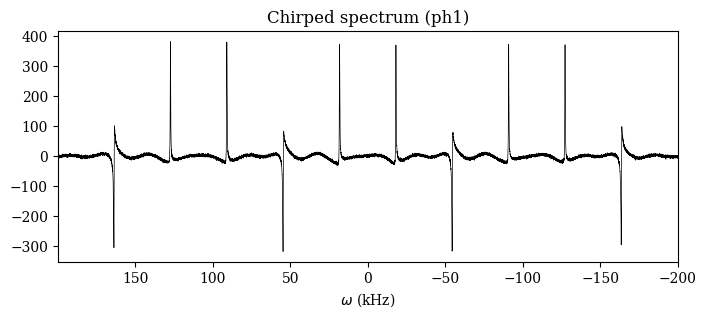

In [6]:
# First order phase correction
ph1corr = chirped.linear_phase()

fig, axs = plt.subplots()
axs.plot(scaledshifts, ph1corr.real, c='k', lw=0.5)
axs.set_xlim((scaledshifts[0], scaledshifts[-1]))
axs.set_xlabel(r'$\omega$ (kHz)')
axs.set_title('Chirped spectrum (ph1)')
plt.show()

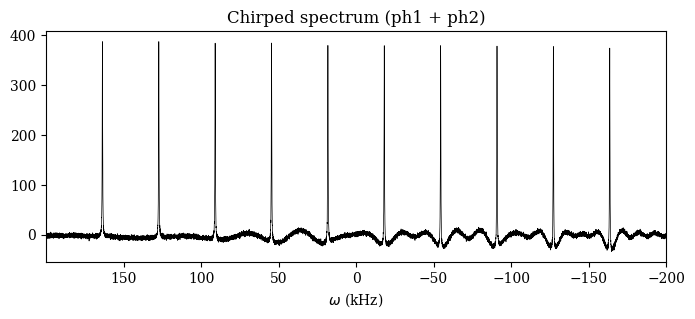

In [7]:
# Second order phase correction
phasecorr = chirped.quadratic_phase()

fig, axs = plt.subplots()
axs.plot(scaledshifts, phasecorr.real, c='k', lw=0.5)
axs.set_xlim((scaledshifts[0], scaledshifts[-1]))
axs.set_xlabel(r'$\omega$ (kHz)')
axs.set_title('Chirped spectrum (ph1 + ph2)')
plt.show()

In [8]:
# Oscillator parameter estimation
chirped.estimate(mpm_trim=4096, nlp_trim=8192)

# Oscillator FID back-extrapolation
bbqfid = chirped.back_extrapolate()
bbqfid[0] *= 0.5
bbqspectrum = ne.sig.ft(bbqfid)

┌────────────────────────┐
│ESTIMATING ENTIRE SIGNAL│
└────────────────────────┘
┌───────────┐
│MPM STARTED│
└───────────┘
--> Pencil Parameter: 1365
--> Hankel data matrix constructed:
	Size:   2731 x 1366
	Memory: 56.9236MiB
--> Performing Singular Value Decomposition...
--> Computing number of oscillators...
	Number of oscillators will be estimated using MDL
	Number of oscillations: 10
--> Computing signal poles...
--> Computing complex amplitudes...
--> Checking for oscillators with negative damping...
	None found
┌────────────┐
│MPM COMPLETE│
└────────────┘
Time elapsed: 0 mins, 7 secs, 891 msecs
┌────────────────────┐
│OPTIMISATION STARTED│
└────────────────────┘
┌───────────────────────────┐
│TRUST NCG ALGORITHM STARTED│
└───────────────────────────┘
┌───────┬──────────────┬──────────────┬──────────────┐
│ Iter. │  Objective   │  Grad. Norm  │ Trust Radius │
├───────┼──────────────┼──────────────┼──────────────┤
│ 0     │ 0.00294443   │ 1.3604e-06   │ 1            │
│ 2     │ 0.

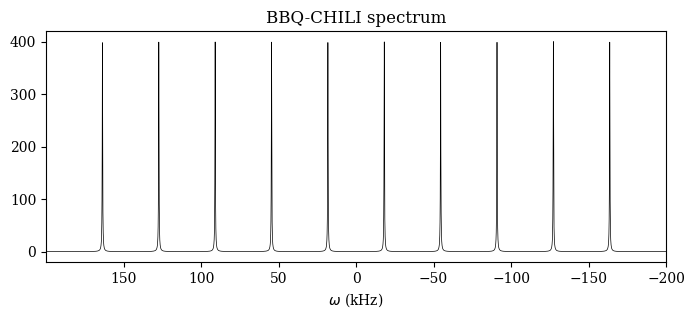

In [9]:
fig, axs = plt.subplots()
axs.plot(scaledshifts, bbqspectrum.real, c='k', lw=0.5)
axs.set_xlim((scaledshifts[0], scaledshifts[-1]))
axs.set_xlabel(r'$\omega$ (kHz)')
axs.set_title('BBQ-CHILI spectrum')
plt.show()